In [1]:
# pylint: disable=C,R,E1101,E1102
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import torch
from s2cnn import S2Convolution, SO3Convolution, so3_rotation
from s2cnn import s2_near_identity_grid, so3_near_identity_grid

def s2_rotation(x, a, b, c):
    x = so3_rotation(x.view(*x.size(), 1).expand(*x.size(), x.size(-1)), a, b, c)
    return x[..., 0]

def plot(x, text, normalize=False):
    print("[def plot(x, text)] input x.shape: ", x.shape)
    assert x.size(0) == 1
    assert x.size(1) in [1, 3]
    x = x[0]
    if x.dim() == 4:
        x = x[..., 0]

    nch = x.size(0)
    is_rgb = (nch == 3)

    if normalize:
        x = x - x.view(nch, -1).mean(-1).view(nch, 1, 1)
        x = 0.4 * x / x.view(nch, -1).std(-1).view(nch, 1, 1)

    x = x.detach().cpu().numpy()
    x = x.transpose((1, 2, 0)).clip(0, 1)

    print("[def plot(x, text)] output x.shape: ", x.shape)
    if is_rgb:
        plt.imshow(x)
    else:
        plt.imshow(x[:, :, 0], cmap='gray')
    plt.axis("off")

    plt.text(0.5, 0.5, text,
             horizontalalignment='center',
             verticalalignment='center',
             transform=plt.gca().transAxes,
             color='white', fontsize=20)

Using TensorFlow backend.


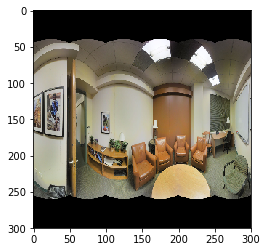

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import img_to_array, load_img
img_rgb = 'C:/Users/ustundag/Desktop/test_pano_rgb.png'

img = load_img(img_rgb, target_size=(300, 300))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
plt.imshow(img)
plt.show()

In [3]:
torch.cuda.empty_cache()  # entirely clear all allocated memory
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

path = 'C:/Users/ustundag/Desktop/s2cnn_TORCH/examples/equivariance_plot/earth128.jpg'
x = imread(path).astype(np.float32).transpose((2, 0, 1)) / 255
b = 64
x = torch.tensor(x, dtype=torch.float, device=device)
x = x.view(1, 3, 2 * b, 2 * b)
x.shape

torch.Size([1, 3, 128, 128])

[def plot(x, text)] input x.shape:  torch.Size([1, 3, 128, 128])
[def plot(x, text)] output x.shape:  (128, 128, 3)
[def phi(x)] input x.shape:  torch.Size([1, 3, 128, 128])
load 0.pkl.gz... done


..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


load 0.pkl.gz... done


..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


load 1.pkl.gz... done
[def phi(x)] s2_conv x.shape:  torch.Size([1, 50, 128, 128, 128])
[def phi(x)] softplus x.shape:  torch.Size([1, 50, 128, 128, 128])
load 0.pkl.gz... 

..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


done
load 0.pkl.gz... done


..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


[def phi(x)] s3_conv x.shape:  torch.Size([1, 1, 128, 128, 128])
[def plot(x, text)] input x.shape:  torch.Size([1, 1, 128, 128, 128])
[def plot(x, text)] output x.shape:  (128, 128, 1)


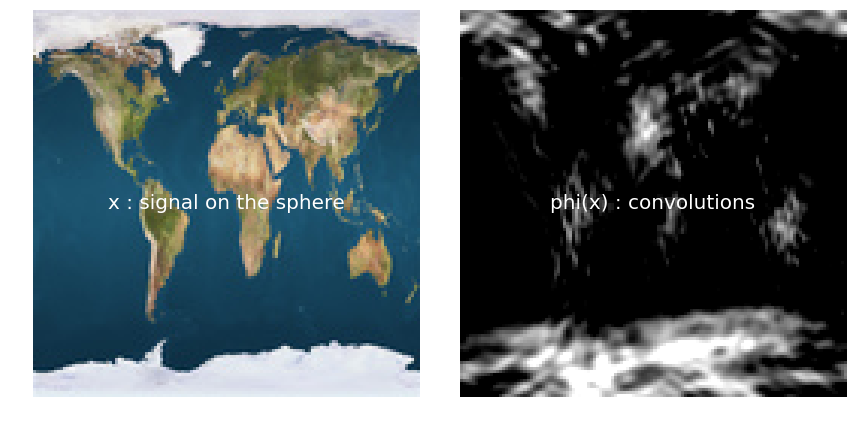

In [4]:
# equivariant transformation
s2_grid = s2_near_identity_grid(max_beta=0.2, n_alpha=12, n_beta=1)
s2_conv = S2Convolution(3, 50, b_in=b, b_out=b, grid=s2_grid)
s2_conv.to(device)

so3_grid = so3_near_identity_grid(max_beta=0.2, n_alpha=12, n_beta=1)
so3_conv = SO3Convolution(50, 1, b_in=b, b_out=b, grid=so3_grid)
so3_conv.to(device)

def phi(x):
    print("[def phi(x)] input x.shape: ", x.shape)
    x = s2_conv(x)
    print("[def phi(x)] s2_conv x.shape: ", x.shape)
    x = torch.nn.functional.softplus(x)
    print("[def phi(x)] softplus x.shape: ", x.shape)
    x = so3_conv(x)
    print("[def phi(x)] s3_conv x.shape: ", x.shape)
    return x

"""
# test equivariance
abc = (0.5, 1, 0)  # rotation angles
y1 = phi(s2_rotation(x, *abc))
y2 = so3_rotation(phi(x), *abc)
print((y1 - y2).std().item(), y1.std().item())
"""

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plot(x, "x : signal on the sphere")
plt.subplot(1, 2, 2)
plot(phi(x), "phi(x) : convolutions", True)
plt.tight_layout()
plt.savefig("fig.jpeg")